Using Tensorflow Object detection API to detect mushrooms in images

In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())


2.17.0
The following GPU devices are available: 


In [2]:
# Functions for displaying images and drawing bounding boxes on them
def display_image(image):
  plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img


def draw_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size

  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)

  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
  # If the total height of the display strings added to the top of the bounding box exceeds the top of the image, stack the strings below the bounding box instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Calculate the total height to display text
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin
  

In [3]:
# Function for drawing a box around the object
def draw_box_on_object(image, boxes, class_names, scores, max_boxes=5, min_score=0.1):
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i].any() >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

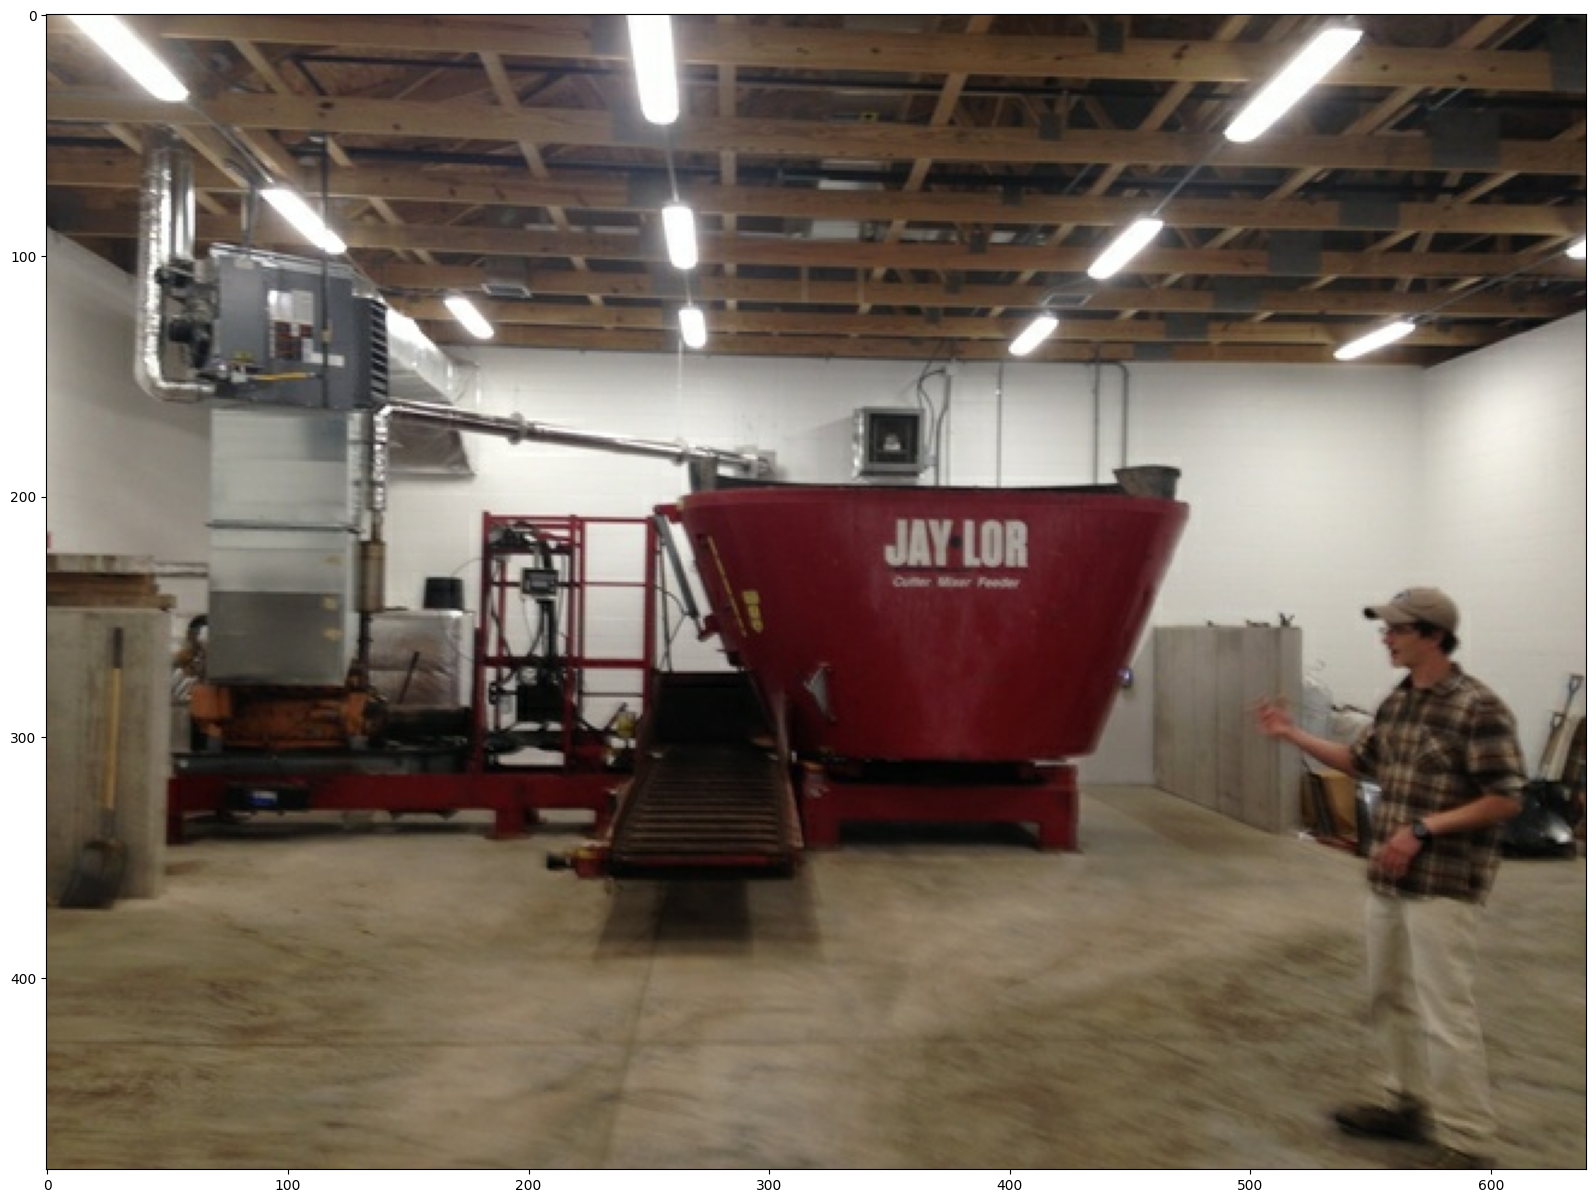

In [4]:
sample_image_path = 'mushrooms_dataset/images/Agaricus_bisporus/614156.jpg'
image = load_img(sample_image_path)
display_image(image)
# image = Image.open(sample_image_path + '.jpg').resize((640,640))

In [5]:
# Now we load the TF-Hub module
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
Inference time:  25.003324508666992


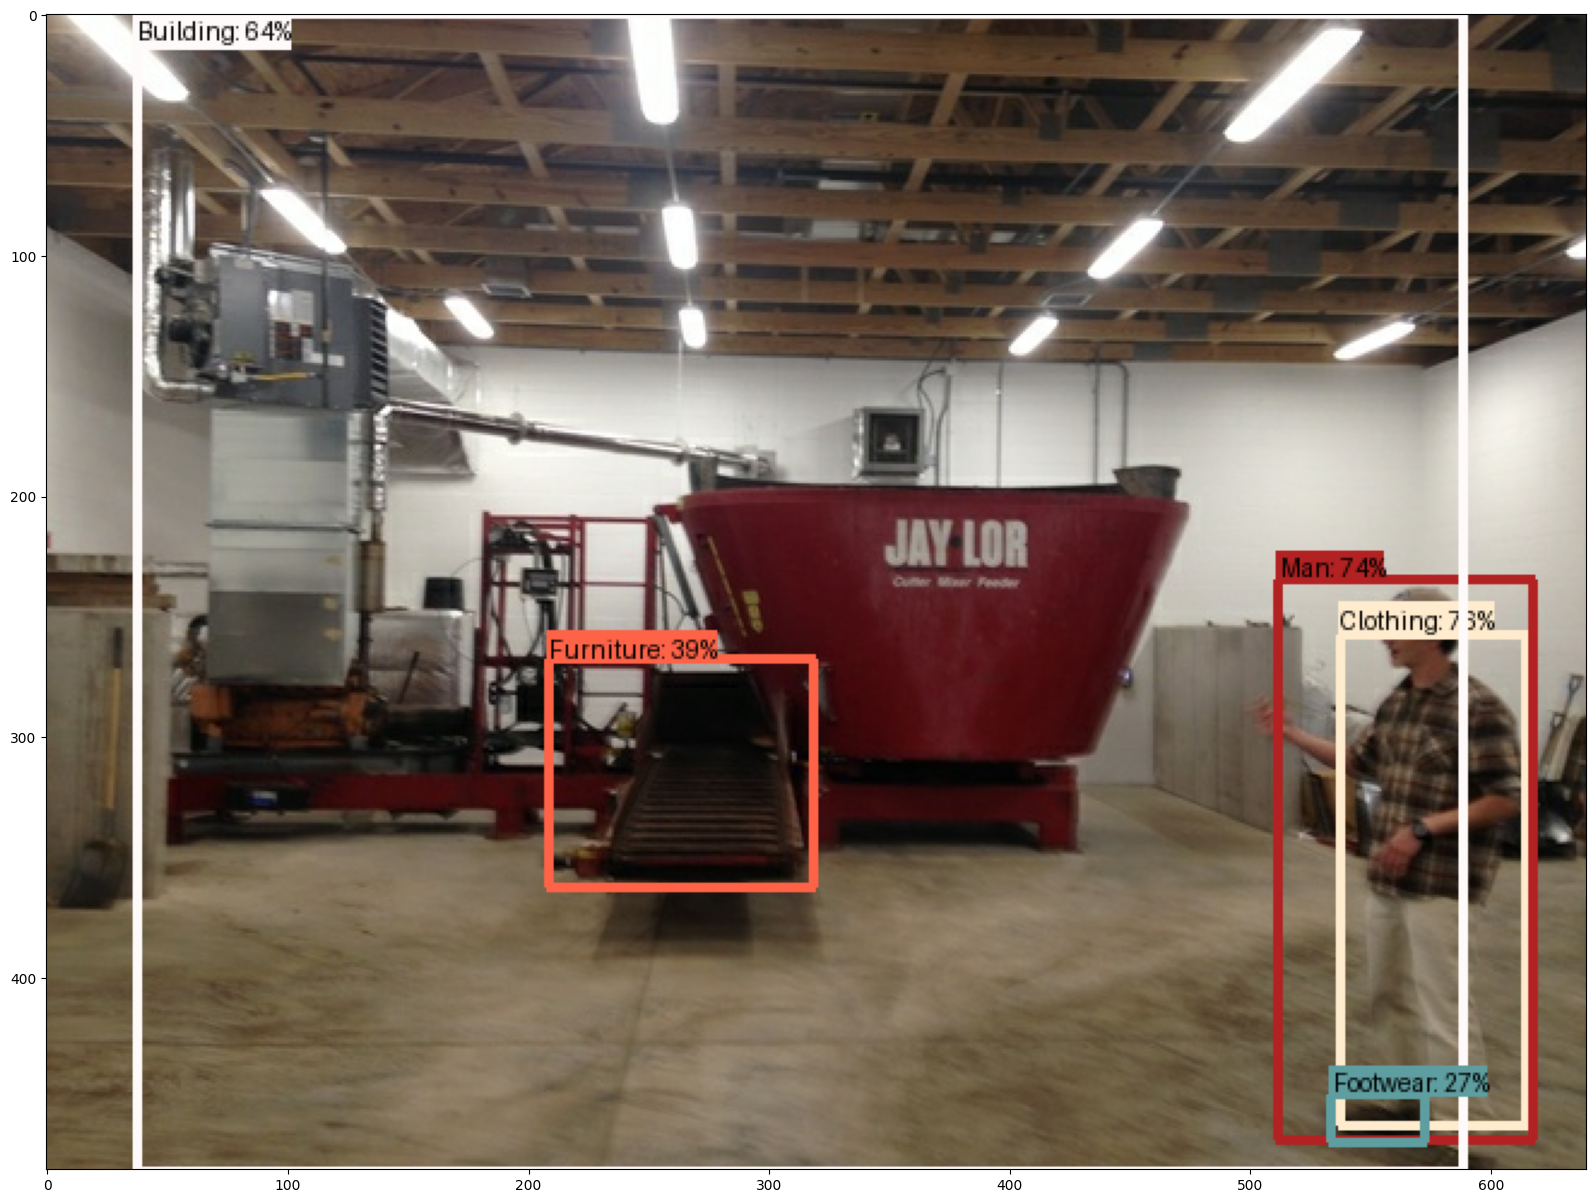

In [6]:
def run_detector(detector, image):
  img = load_img(image)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()


  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)
  
  image_with_boxes = draw_box_on_object(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  display_image(image_with_boxes)

run_detector(detector, sample_image_path)

In [12]:
def detect_img(image_path):
  start_time = time.time()
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time: ", end_time-start_time)
  

Found 100 objects.
Inference time:  2.3212976455688477
Inference time:  2.3327274322509766


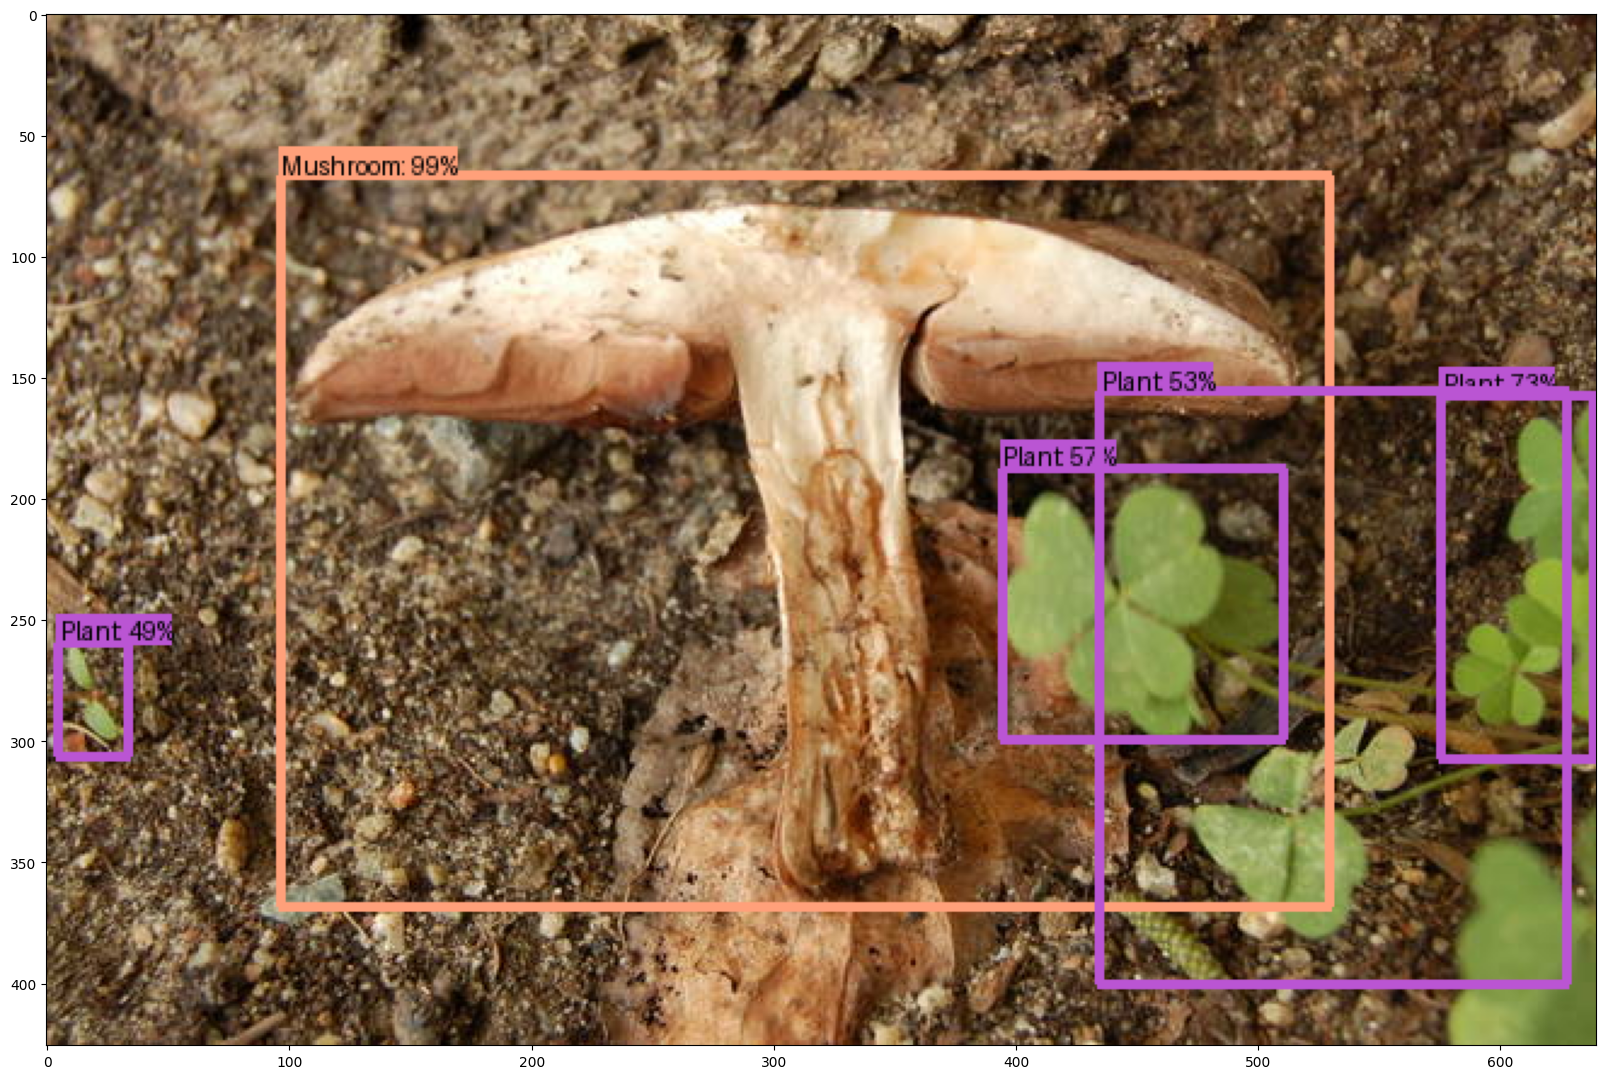

In [13]:
detect_img('mushrooms_dataset/images/Agaricus_bisporus/869.jpg')

In [1]:
#Make a file with mushroom names
import os
def get_mushroom_names():
    mushroom_names = []
    for mushroom in os.listdir('mushrooms_dataset/images'):
        mushroom_names.append(mushroom)
    with open('mushroom_names.txt', 'w') as f:
        for item in mushroom_names:
            f.write("%s\n" % item)


In [2]:
get_mushroom_names()